# Homework 2, *part 2*
### (60 points total)

In this part, you will build a convolutional neural network (CNN) to solve (yet another) image classification problem: the Tiny ImageNet dataset (200 classes, 100K training images, 10K validation images). Try to achieve as high accuracy as possible.

**Unlike part 1**, you are now free to use the full power of PyTorch and its subpackages.

## Deliverables

* This file.
* A "checkpoint file" `"checkpoint.pth"` that contains your CNN's weights (you get them from `model.state_dict()`). Obtain it with `torch.save(..., "checkpoint.pth")`. When grading, we will load it to evaluate your accuracy.

**Should you decide to put your `"checkpoint.pth"` on Google Drive, update (edit) the following cell with the link to it:**

### [Dear TAs, I've put my "checkpoint.pth" on Google Drive, download it here](https://drive.google.com/drive/folders/1r0UfdTCxH-vG8NTTFM-RM5NnLeHTEnDp?usp=sharing)

## Grading

* 9 points for reproducible training code and a filled report below.
* 11 points for building a network that gets above 25% accuracy.
* 4 points for using an **interactive** (please don't reinvent the wheel with `plt.plot`) tool for viewing progress, for example Tensorboard ([with this library](https://github.com/lanpa/tensorboardX) and [an extra hack for Colab](https://stackoverflow.com/a/57791702)). In this notebook, insert screenshots of accuracy and loss plots (training and validation) over iterations/epochs/time.
* 6 points for beating each of these accuracy milestones on the private **test** set:
  * 30%
  * 34%
  * 38%
  * 42%
  * 46%
  * 50%
  
*Private test set* means that you won't be able to evaluate your model on it. Rather, after you submit code and checkpoint, we will load your model and evaluate it on that test set ourselves, reporting your accuracy in a comment to the grade.

Note that there is an important formatting requirement, see below near "`DO_TRAIN = True`".

## Restrictions

* No pretrained networks.
* Don't enlarge images (e.g. don't resize them to $224 \times 224$ or $256 \times 256$).

## Tips

* **One change at a time**: never test several new things at once (unless you are super confident). Train a model, introduce one change, train again.
* Google a lot: try to reinvent as few wheels as possible (unlike in part 1 of this assignment).
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation...
* Pay much attention to accuracy and loss graphs (e.g. in Tensorboard). Track failures early, stop bad experiments early.

In [1]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The below cell puts training and validation images in `./tiny-imagenet-200/train` and `./tiny-imagenet-200/val`:

In [0]:
# Extract the dataset into the current directory
if not Path("tiny-imagenet-200/train/class_000/00000.jpg").is_file():
    import zipfile
    with zipfile.ZipFile(AUX_DATA_ROOT / 'tiny-imagenet-2020.zip', 'r') as archive:
        archive.extractall()

**You are required** to format your notebook cells so that `Run All` on a fresh notebook:
* trains your model from scratch, if `DO_TRAIN is True`;
* loads your trained model from `"./checkpoint.pth"`, then **computes** and prints its validation accuracy, if `DO_TRAIN is False`.

In [0]:
DO_TRAIN = False

## Train the model

In [0]:
# Your code here (feel free to add cells)
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [0]:
train_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', 
                                                 transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation((-10,10)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=0.3, interpolation=3, fill=0),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]))

val_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', 
                                               transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]))

In [0]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=100,
                                               shuffle=True,
                                               num_workers=2)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=100,
                                             num_workers=1)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
model = torchvision.models.densenet201(pretrained=False, num_classes = 200).to(device)

In [0]:
writer = SummaryWriter()

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss().to(device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
n_epochs = 30

In [0]:
def compute_accuracy(model, loader, device = 'cuda'):
    model.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            pred = torch.argmax(output, dim = -1)
            correct += torch.sum(torch.eq(pred, labels)).item()
    accuracy = correct / len(loader.dataset)
    return accuracy * 100

In [13]:
!wget -O utils.py https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
!pip install einops

--2020-04-30 07:27:09--  https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
Resolving drive.google.com (drive.google.com)... 74.125.31.113, 74.125.31.100, 74.125.31.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.31.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v8t21g204i75mef5lf4l081af2rm1233/1588231575000/11513719840956837432/*/1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml [following]
--2020-04-30 07:27:09--  https://doc-0g-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v8t21g204i75mef5lf4l081af2rm1233/1588231575000/11513719840956837432/*/1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
Resolving doc-0g-6g-docs.googleusercontent.com (doc-0g-6g-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to doc-0g-6g-docs.googleusercontent.com (doc-0g-6g-docs.googleusercontent.com)|74.125.31.1

In [14]:
%load_ext tensorboard
import os
logs_base_dir = "./runs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

<IPython.core.display.Javascript object>

In [0]:
max_val_accuracy = 0

In [0]:
if DO_TRAIN:
    for i in range(n_epochs):

        train_loss = 0
        val_loss = 0
      
        train_accuracy = 0
        val_accuracy = 0

        # Train
        model.train(True)

        for X_batch, y_batch in train_dataloader:
          
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model.forward(X_batch)
            loss = criterion(y_pred, y_batch)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_dataloader)

        # Validation
        model.train(False)
        for X_batch, y_batch in val_dataloader:
        
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
      
        scheduler.step(val_loss)
    
        train_accuracy = compute_accuracy(model, train_dataloader)
        val_accuracy = compute_accuracy(model, val_dataloader)

        writer.add_scalar('Train Loss', loss, i)
        writer.add_scalar('Val Loss', loss, i)
        writer.add_scalar('Train Accuracy', train_accuracy, i)
        writer.add_scalar('Val Accuracy', val_accuracy, i)
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            torch.save(model.state_dict(), './densenet_best_params.pt')
        print(val_accuracy)

16.509999999999998
24.91
30.009999999999998
33.58
36.35
36.730000000000004
42.3
42.809999999999995
43.7
44.95
44.48
44.72
Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
45.03
49.94
50.019999999999996
49.89
Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
49.919999999999995
50.21
50.019999999999996
Epoch    20: reducing learning rate of group 0 to 1.0000e-06.
50.46000000000001
50.44
50.33
Epoch    23: reducing learning rate of group 0 to 1.0000e-07.
50.160000000000004
50.13999999999999
50.260000000000005
Epoch    26: reducing learning rate of group 0 to 1.0000e-08.
50.05
50.160000000000004
50.22
50.03999999999999


## Load and evaluate the model

In [0]:
# Your code here (load the model from "./checkpoint.pth")
# Please use `torch.load("checkpoint.pth", map_location='cpu')`

In [22]:
if not DO_TRAIN:
    model.load_state_dict(torch.load('/content/densenet_best_params.pt', map_location='cpu'))
    model.to(device)
    model.eval()
    val_accuracy = compute_accuracy(model, val_dataloader)
    assert 0 <= val_accuracy <= 100
    print("Validation accuracy: %.2f%%" % val_accuracy)

Validation accuracy: 50.46%


# Report

Below, please mention:

* A brief history of tweaks and improvements.
* Which network architectures have you tried? What is the final one and why?
* What is the training method (batch size, optimization algorithm, number of iterations, ...) and why?
* Which techniques have you tried to prevent overfitting? What were their effects? Which of them worked well?
* Any other insights you learned.

For example, start with:

"I have analyzed these and those conference papers/sources/blog posts. \
I tried this and that to adapt them to my problem. \
The conclusions this task taught me are ..."

**A brief history of tweaks and improvements:**
* I first started with research on ImageNet competition results assuming close performance on Tiny-ImageNet. I find a plot of all architectures used on ImageNet https://arxiv.org/abs/1810.00736 and focused on the most energy-efficient yet with good Top-1 score models, because I didn't have a cloud or good GPU, so I know that I need to be very efficient and fast while training. I picked MobileNetV2 https://arxiv.org/abs/1801.04381.

* Run Shallow MobileNetV2, early stopping on **~25%** validation accuracy.
* Add data augmentation and run MobileNetV2, good results with **43.55%** validation accuracy.
* Switch to DenseNet201 https://arxiv.org/abs/1608.06993, achieved **50.46%** validation accuracy.

---
**Which network architectures have you tried? What is the final one and why?**

MobileNetV2 and DenseNet201. Both are comparably effient models that scored well on ImageNet. Final model is DenseNet201, because it has performed better in my experiments.


---
**What is the training method (batch size, optimization algorithm, number of iterations, ...) and why?**

Batch size = 100 - chose at the beginning, so that the training step is not too slow.

Optimization algorithm - Adam, just because it is superior to SGD overall. (didn't tweak it)

Number of iterations: initially 20 epoches for first MobeileNetV2, then changed to 30 epoches.

---
**Which techniques have you tried to prevent overfitting? What were their effects? Which of them worked well?**

I used severe **data augmentation** and it helped me a lot to keep the validation loss curve going down. Basically it is the second major thing I did after researching and choosing the models.

---
**Any other insights you learned**

Initialization and early detection of bad initilization are very important in getting good model, I trained two DenseNet201 on two laptops in the end, because on the first one initialized badly and trained for a long time, but I didn't wanted to stop it, because it already took so much time. It eventually converged to **~44%** validation accuracy.

## Unfortunately my events files were erased when I trained DenseNet, so there is only the validation accuracy for MobileNetV2:

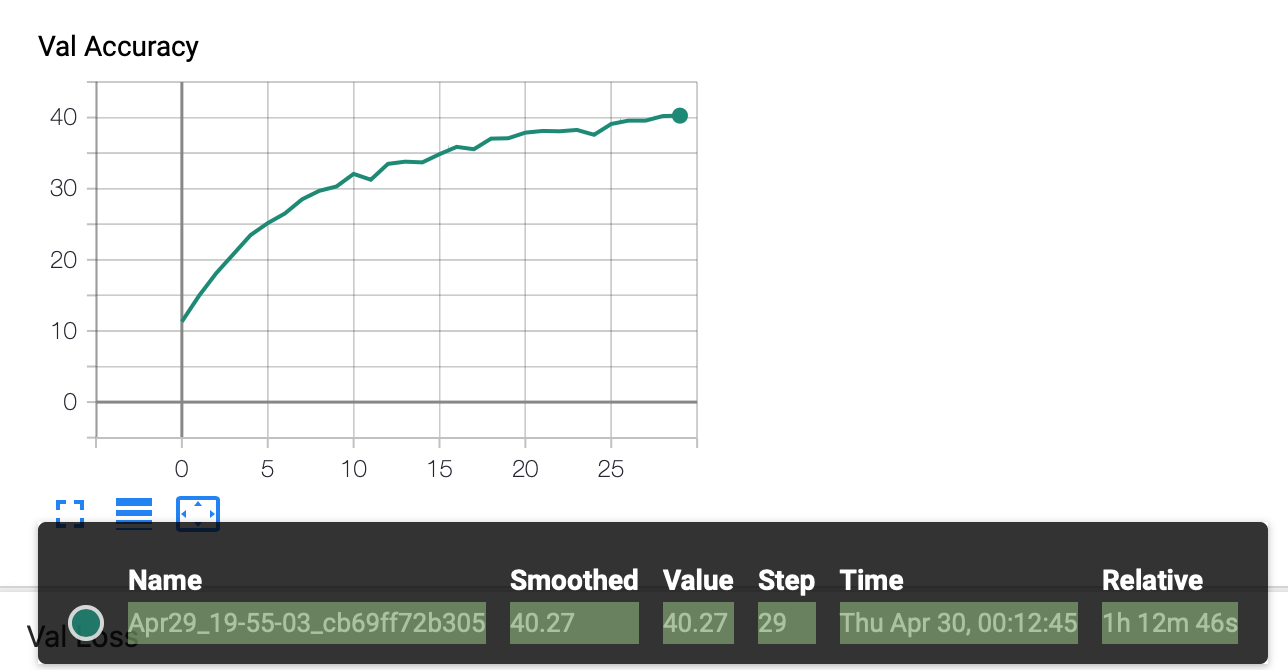

# You can see the eficiency of MobileNetV2 and DenseNet201 here:

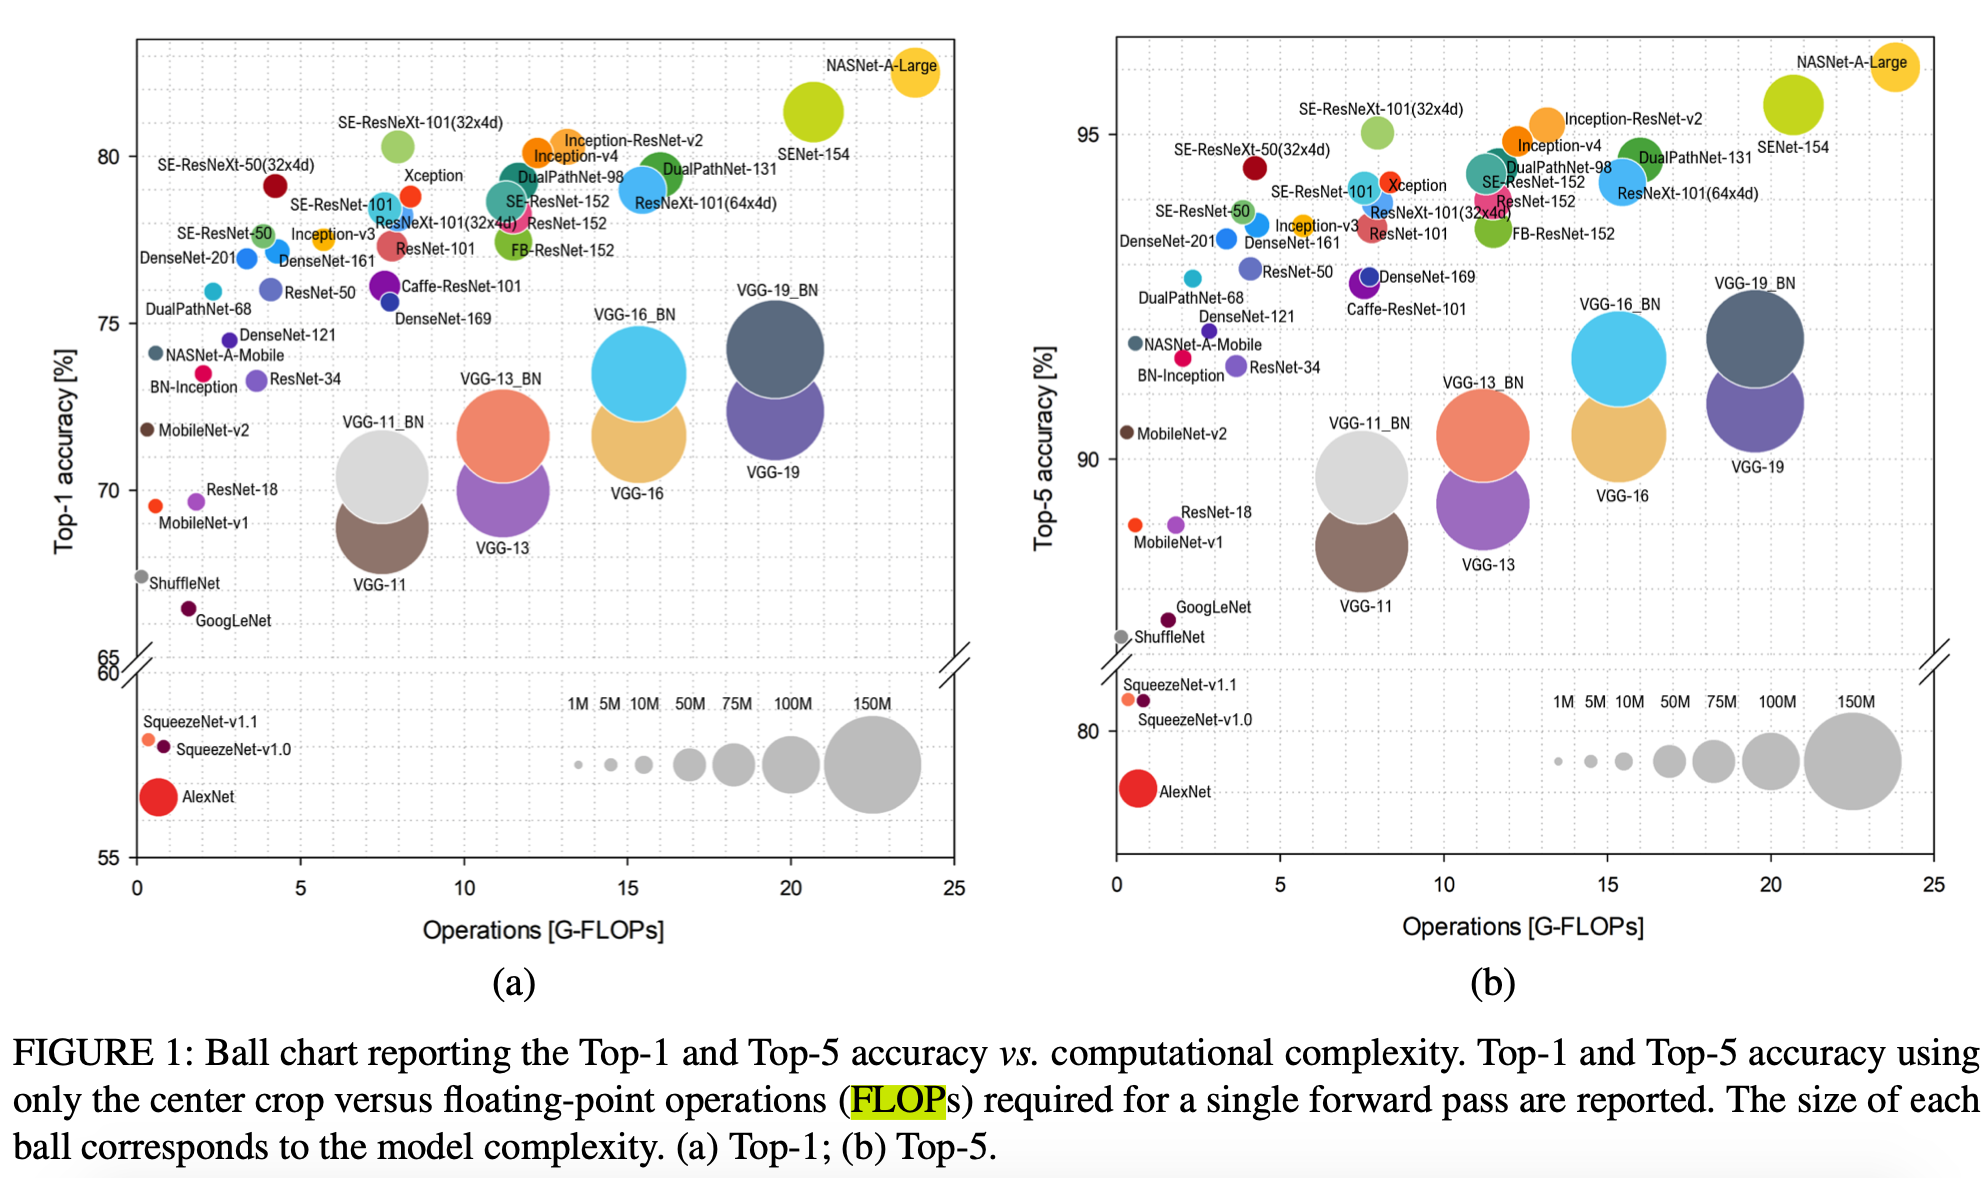